In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from lxml import etree
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
annotations_dir = "archive/annotations/"
images_dir = "archive/images/"

# Define classes
classes = ['With Helmet', 'Without Helmet']

In [3]:
def parse_annotation(annotation_file):
    tree = etree.parse(annotation_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text), int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text), int(bbox.find('ymax').text)]
        objects.append(obj_struct)
    return objects

In [4]:
import xml.etree.ElementTree as etree
from tensorflow.keras.applications.resnet50 import preprocess_input


def load_data(annotations_dir, images_dir):
    X, y = [], []
    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            objects = parse_annotation(annotation_path)
            image_path = os.path.join(images_dir, annotation_file.replace('.xml', '.png'))
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            X.append(preprocess_input(image))  # Now preprocess_input is properly imported
            labels = [0] * len(classes)
            for obj in objects:
                label_idx = classes.index(obj['name'])
                labels[label_idx] = 1
            y.append(labels)
    return np.array(X), np.array(y)

# Load and preprocess data
X_train, y_train = load_data(annotations_dir, images_dir)

# Check the shape of the loaded data
print("Loaded images shape:", X_train.shape)
print("Loaded labels:", y_train.shape)

ModuleNotFoundError: No module named 'tensorflow'

In [47]:
# Split data into training and testing sets (80% train, 20% test)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the shapes of the split data
print("Training data shape:", X_train_split.shape)
print("Testing data shape:", X_test_split.shape)
print("Training labels shape:", y_train_split.shape)
print("Testing labels shape:", y_test_split.shape)

Training data shape: (611, 224, 224, 3)
Testing data shape: (153, 224, 224, 3)
Training labels shape: (611, 2)
Testing labels shape: (153, 2)


In [48]:
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_model()

In [49]:
"""
Compute class weights to address class imbalance in the dataset.
"""
train_labels = classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: np.float64(1.0), 1: np.float64(1.0)}


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(2, activation='softmax')  # 2 classes: With Helmet, Without Helmet
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



/home/komal/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,827,586 (98.52 MB)

 Trainable params: 25,826,242 (98.52 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [51]:
# Train the model
history = model.fit(
    X_train_split, y_train_split,  # Training data and labels
    epochs=20,         # Number of epochs
    batch_size=16,     # Batch size
    validation_data=(X_test_split, y_test_split),  # Test data and labels for validation
    verbose=2          # To print detailed logs
)


Epoch 1/20
39/39 - 173s - 4s/step - accuracy: 0.5516 - loss: 18.7947 - val_accuracy: 0.7386 - val_loss: 20.4079
Epoch 2/20
39/39 - 150s - 4s/step - accuracy: 0.7561 - loss: 17.1516 - val_accuracy: 0.6993 - val_loss: 15.1410
Epoch 3/20
39/39 - 150s - 4s/step - accuracy: 0.8412 - loss: 13.2480 - val_accuracy: 0.7190 - val_loss: 12.0780
Epoch 4/20
39/39 - 148s - 4s/step - accuracy: 0.7856 - loss: 12.5135 - val_accuracy: 0.7386 - val_loss: 12.7086
Epoch 5/20
39/39 - 148s - 4s/step - accuracy: 0.8101 - loss: 11.9452 - val_accuracy: 0.6993 - val_loss: 10.9465
Epoch 6/20
39/39 - 149s - 4s/step - accuracy: 0.8478 - loss: 11.2426 - val_accuracy: 0.7386 - val_loss: 11.6810
Epoch 7/20
39/39 - 147s - 4s/step - accuracy: 0.8396 - loss: 11.9928 - val_accuracy: 0.7124 - val_loss: 11.5869
Epoch 8/20
39/39 - 208s - 5s/step - accuracy: 0.8249 - loss: 10.8341 - val_accuracy: 0.8039 - val_loss: 10.3753
Epoch 9/20
39/39 - 151s - 4s/step - accuracy: 0.8625 - loss: 10.6426 - val_accuracy: 0.7712 - val_loss: 

In [52]:
test_loss, test_acc = model.evaluate(X_test_split, y_test_split, batch_size=8, verbose=2)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)



20/20 - 9s - 470ms/step - accuracy: 0.7320 - loss: 17.3479
Test Loss: 17.347850799560547
Test Accuracy: 0.7320261597633362


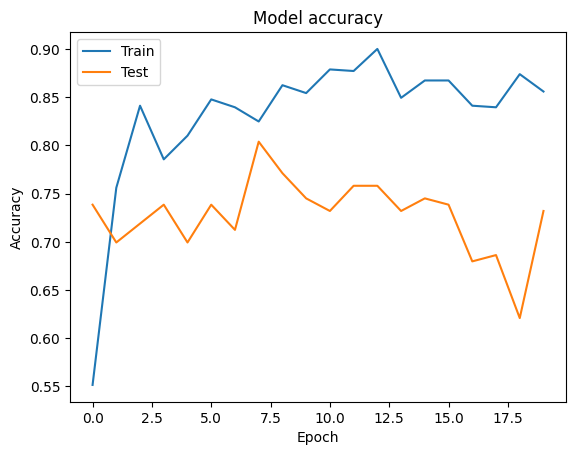

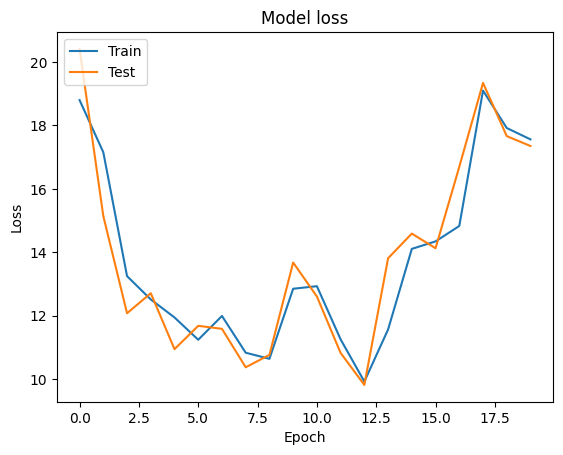

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
predictions = model.predict(X_test_split)

# Convert predictions to labels (since the output is sigmoid, threshold is 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Display some predictions with corresponding actual labels
for i in range(5):
    print(f"Predicted: {predicted_labels[i]}, Actual: {y_test_split[i]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Predicted: [1 0], Actual: [1 0]
Predicted: [1 0], Actual: [1 0]
Predicted: [1 0], Actual: [1 0]
Predicted: [1 0], Actual: [1 0]
Predicted: [0 1], Actual: [0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].


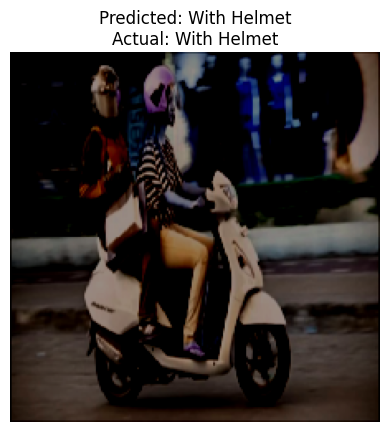

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].


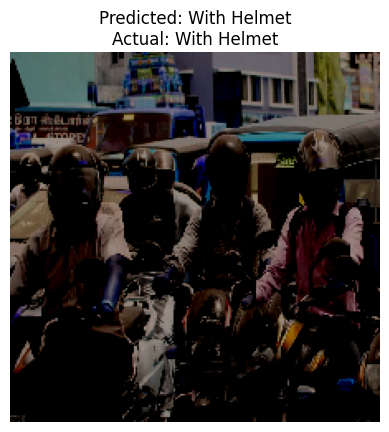

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].


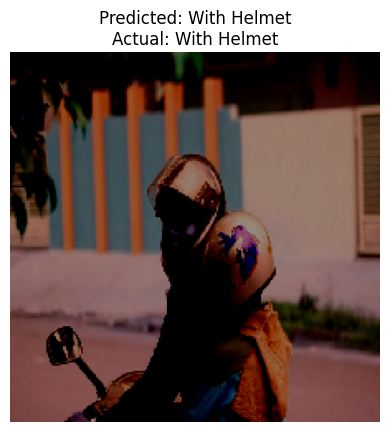

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37521568..0.5923961].


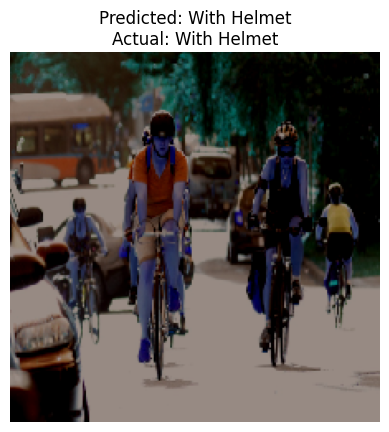

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].


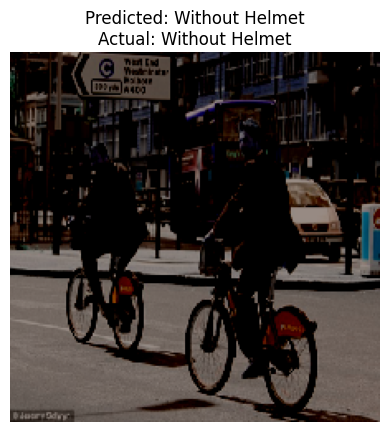

In [55]:
# Plot some of the test images with predicted and actual labels
for i in range(5):
    # Load the image from the test set
    image = X_test_split[i]

    # Convert the image from (224, 224, 3) to (224, 224, 3)
    image = image / 255.0  # Rescale to [0, 1] range for visualization

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

    # Display predicted and actual labels
    predicted_class = classes[np.argmax(predicted_labels[i])]
    actual_class = classes[np.argmax(y_test_split[i])]

    plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}")
    plt.show()

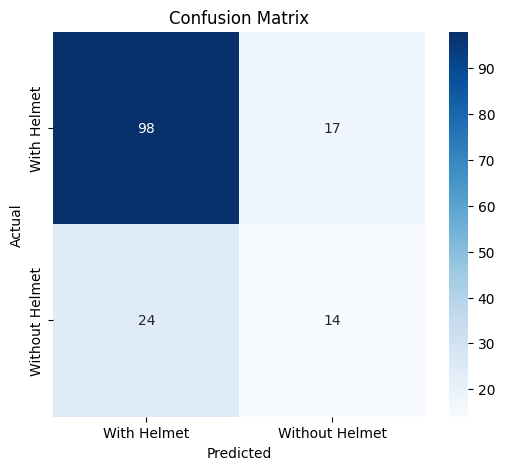

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels
y_true = np.argmax(y_test_split, axis=1)  # True labels
y_pred = np.argmax(predicted_labels, axis=1)  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [57]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.
